In [ ]:

from google.colab import files
files.upload() ## Upload your kaggle.json here
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!mkdir FruitRecognition
%cd FruitRecognition
!pwd #Print Working Directory
!kaggle datasets download -d utkarshsaxenadn/fruits-classification



In [ ]:
!unzip fruits-classification.zip

In [ ]:
import keras, os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import regularizers
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from glob import glob
from IPython.display import display, Markdown, Latex
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
trainpaths=[]
for name in glob('/content/FruitRecognition/Fruits Classification/train/*', recursive=True):
  if not name.endswith('.zip'):
    trainpaths.append(name)
valpaths=[]
for name in glob('/content/FruitRecognition/Fruits Classification/valid/*', recursive=True):
  if not name.endswith('.zip'):
    valpaths.append(name)
testpaths=[]
for name in glob('/content/FruitRecognition/Fruits Classification/test/*', recursive=True):
  if not name.endswith('.zip'):
    testpaths.append(name)
print(trainpaths)
print(valpaths)
print(testpaths)

['/content/FruitRecognition/Fruits Classification/train/Apple', '/content/FruitRecognition/Fruits Classification/train/Mango', '/content/FruitRecognition/Fruits Classification/train/Strawberry', '/content/FruitRecognition/Fruits Classification/train/Grape', '/content/FruitRecognition/Fruits Classification/train/Banana']
['/content/FruitRecognition/Fruits Classification/valid/Apple', '/content/FruitRecognition/Fruits Classification/valid/Mango', '/content/FruitRecognition/Fruits Classification/valid/Strawberry', '/content/FruitRecognition/Fruits Classification/valid/Grape', '/content/FruitRecognition/Fruits Classification/valid/Banana']
['/content/FruitRecognition/Fruits Classification/test/Apple', '/content/FruitRecognition/Fruits Classification/test/Mango', '/content/FruitRecognition/Fruits Classification/test/Strawberry', '/content/FruitRecognition/Fruits Classification/test/Grape', '/content/FruitRecognition/Fruits Classification/test/Banana']


In [ ]:
train_img_paths=[]
train_labels=[]
for i in trainpaths:
  for name in glob(i+'/*'):
    a=name.split('/')
    train_img_paths.append(name)
    train_labels.append(a[-2])

val_img_paths=[]
val_labels=[]
for i in valpaths:
  for name in glob(i+'/*'):
    a=name.split('/')
    val_img_paths.append(name)
    val_labels.append(a[-2])

test_img_paths=[]
test_labels=[]
for i in testpaths:
  for name in glob(i+'/*'):
    a=name.split('/')
    test_img_paths.append(name)
    test_labels.append(a[-2])

print(len(train_img_paths))
print(len(val_img_paths))
print(len(test_img_paths))
print(set(train_labels))

9700
200
100
{'Mango', 'Strawberry', 'Grape', 'Apple', 'Banana'}


#*Count Plot of Train data in data set:*

<Axes: xlabel='1', ylabel='count'>

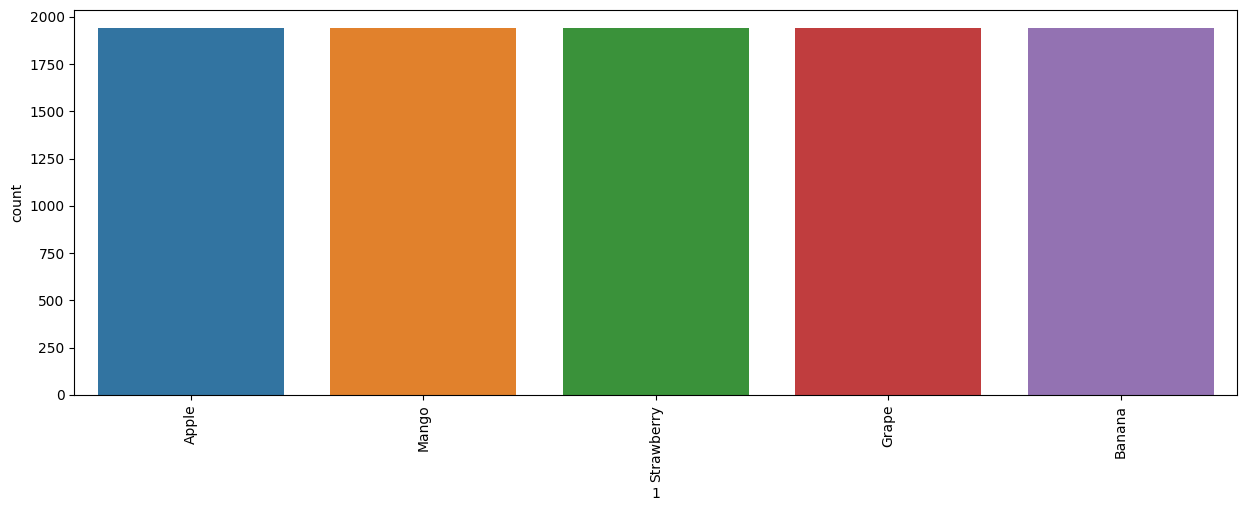

In [ ]:
trainImgPath = pd.Series(train_img_paths).astype(str)
trainLabels=pd.Series(train_labels)
trainData = pd.concat([trainImgPath,trainLabels],axis=1)
display(Markdown("#*Count Plot of Train data in data set:*"))
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.countplot(x=trainData[1], order=trainData[1].value_counts().index)

#*Count Plot of Validation data in data set:*

<Axes: xlabel='1', ylabel='count'>

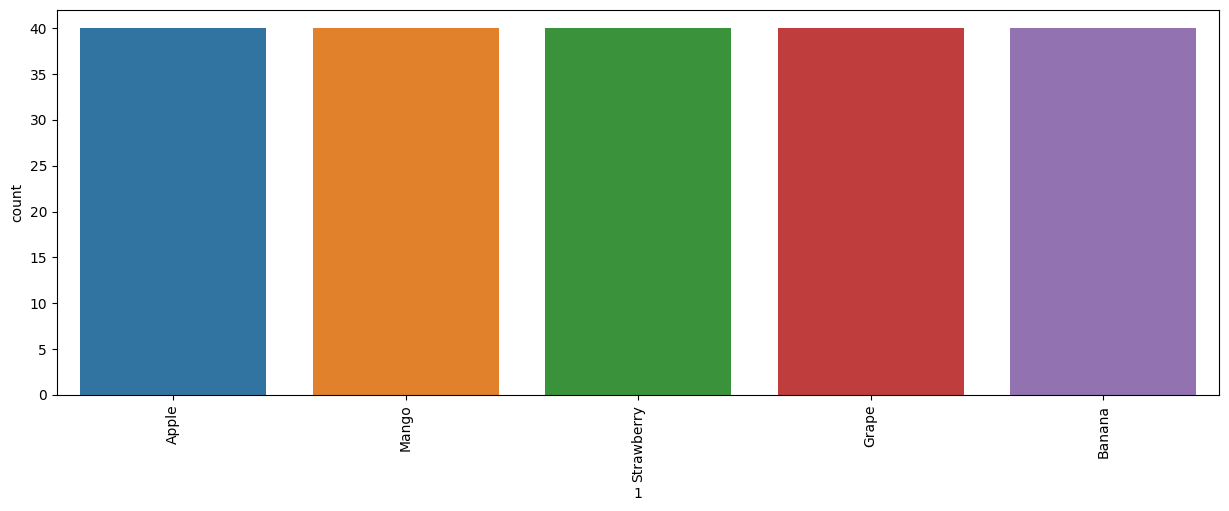

In [ ]:
valImgPath = pd.Series(val_img_paths).astype(str)
valLabels=pd.Series(val_labels)
valData = pd.concat([valImgPath,valLabels],axis=1)
display(Markdown("#*Count Plot of Validation data in data set:*"))
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.countplot(x=valData[1], order=valData[1].value_counts().index)

#*Count Plot of Test data in data set:*

<Axes: xlabel='1', ylabel='count'>

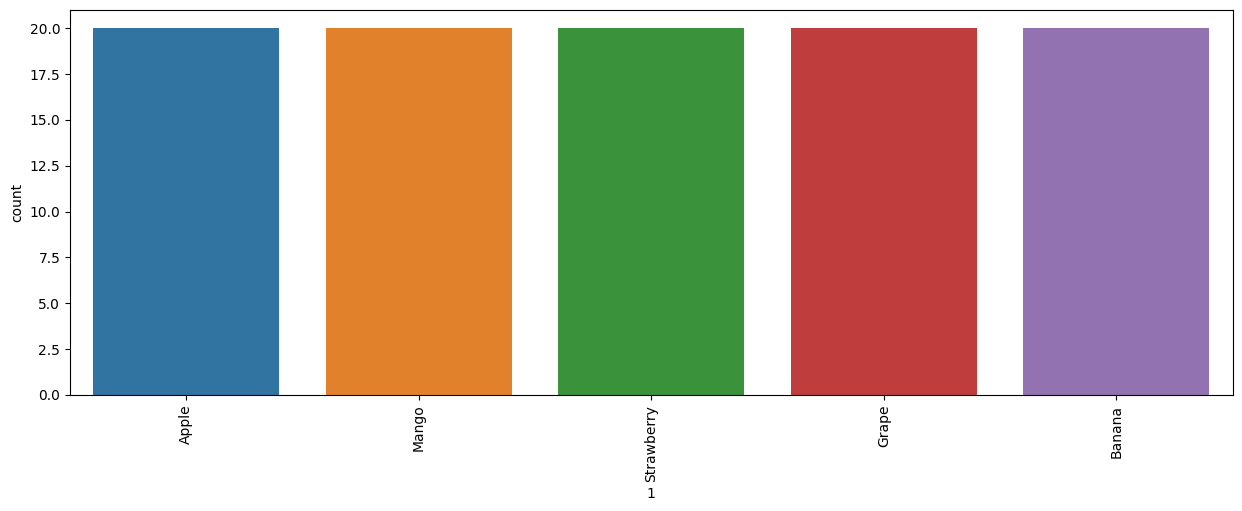

In [ ]:
testImgPath = pd.Series(test_img_paths).astype(str)
testLabels=pd.Series(test_labels)
testData = pd.concat([testImgPath,testLabels],axis=1)
display(Markdown("#*Count Plot of Test data in data set:*"))
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.countplot(x=testData[1], order=testData[1].value_counts().index)

In [ ]:
train_gen = ImageDataGenerator()
aug_gen = ImageDataGenerator(
          rotation_range=10, # rotation
          width_shift_range=0.2, # horizontal shift
          height_shift_range=0.2, # vertical shift
          zoom_range=0.2, # zoom
          horizontal_flip=True, # horizontal flip
          brightness_range=[0.2,1.2]) # brightness
val_gen = ImageDataGenerator()
test_gen = ImageDataGenerator()

train_data = train_gen.flow_from_dataframe(
    dataframe = trainData,
    x_col = 0,
    y_col = 1,
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True
)

aug_data = aug_gen.flow_from_dataframe(
    dataframe = trainData,
    x_col = 0,
    y_col = 1,
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True
)

val_data = val_gen.flow_from_dataframe(
    dataframe = valData,
    x_col = 0,
    y_col = 1,
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True
)

test_data = test_gen.flow_from_dataframe(
    dataframe = testData,
    x_col = 0,
    y_col = 1,
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False
)


Found 9700 validated image filenames belonging to 5 classes.
Found 9700 validated image filenames belonging to 5 classes.
Found 200 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu",activity_regularizer=regularizers.L2(0.01)))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1000, activation="relu"))
model.add(Dense(units=5, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [ ]:
model.compile(
    optimizer = tf.optimizers.SGD(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
def combine_gen(*gens):
    while True:
        for g in gens:
            yield next(g)

In [ ]:
history1 = model.fit(combine_gen(train_data, aug_data), steps_per_epoch=len(train_data)+len(aug_data), epochs=10, validation_data=val_data)

Epoch 1/10
608/608 [==============================] - 386s 593ms/step - loss: 1.5052 - accuracy: 0.3615 - val_loss: 1.4278 - val_accuracy: 0.4250
Epoch 2/10
608/608 [==============================] - 352s 578ms/step - loss: 1.2602 - accuracy: 0.4794 - val_loss: 1.3849 - val_accuracy: 0.3850
Epoch 3/10
608/608 [==============================] - 353s 580ms/step - loss: 1.1749 - accuracy: 0.5110 - val_loss: 1.2094 - val_accuracy: 0.4650
Epoch 4/10
608/608 [==============================] - 353s 580ms/step - loss: 1.1209 - accuracy: 0.5368 - val_loss: 1.2668 - val_accuracy: 0.4550
Epoch 5/10
608/608 [==============================] - 353s 581ms/step - loss: 1.0785 - accuracy: 0.5580 - val_loss: 1.8774 - val_accuracy: 0.2700
Epoch 6/10
608/608 [==============================] - 353s 581ms/step - loss: 1.0645 - accuracy: 0.5660 - val_loss: 1.5616 - val_accuracy: 0.4000
Epoch 7/10
608/608 [==============================] - 353s 580ms/step - loss: 1.0114 - accuracy: 0.6013 - val_loss: 1.6658 -

In [ ]:
history2 = model.fit(combine_gen(train_data, aug_data), steps_per_epoch=len(train_data)+len(aug_data), epochs=10, validation_data=val_data)

Epoch 1/10
608/608 [==============================] - 353s 581ms/step - loss: 0.8676 - accuracy: 0.6722 - val_loss: 0.9239 - val_accuracy: 0.6500
Epoch 2/10
608/608 [==============================] - 353s 581ms/step - loss: 0.8312 - accuracy: 0.6895 - val_loss: 0.8411 - val_accuracy: 0.6600
Epoch 3/10
608/608 [==============================] - 353s 580ms/step - loss: 0.7978 - accuracy: 0.7026 - val_loss: 1.1427 - val_accuracy: 0.5150
Epoch 4/10
608/608 [==============================] - 353s 581ms/step - loss: 0.7795 - accuracy: 0.7127 - val_loss: 1.2086 - val_accuracy: 0.4800
Epoch 5/10
608/608 [==============================] - 353s 581ms/step - loss: 0.7374 - accuracy: 0.7265 - val_loss: 2.0010 - val_accuracy: 0.5050
Epoch 6/10
608/608 [==============================] - 354s 582ms/step - loss: 0.7361 - accuracy: 0.7285 - val_loss: 1.3858 - val_accuracy: 0.4900
Epoch 7/10
608/608 [==============================] - 351s 577ms/step - loss: 0.6976 - accuracy: 0.7472 - val_loss: 1.4463 -

In [ ]:
history3 = model.fit(combine_gen(train_data, aug_data), steps_per_epoch=len(train_data)+len(aug_data), epochs=10, validation_data=val_data)

Epoch 1/10
608/608 [==============================] - 355s 584ms/step - loss: 0.5788 - accuracy: 0.7952 - val_loss: 0.9205 - val_accuracy: 0.6800
Epoch 2/10
608/608 [==============================] - 354s 583ms/step - loss: 0.5548 - accuracy: 0.8029 - val_loss: 1.6522 - val_accuracy: 0.4700
Epoch 3/10
608/608 [==============================] - 353s 581ms/step - loss: 0.5321 - accuracy: 0.8124 - val_loss: 1.3769 - val_accuracy: 0.4900
Epoch 4/10
608/608 [==============================] - 352s 580ms/step - loss: 0.5185 - accuracy: 0.8182 - val_loss: 0.8506 - val_accuracy: 0.7050
Epoch 5/10
608/608 [==============================] - 354s 582ms/step - loss: 0.4878 - accuracy: 0.8301 - val_loss: 2.2953 - val_accuracy: 0.4450
Epoch 6/10
608/608 [==============================] - 353s 580ms/step - loss: 0.4769 - accuracy: 0.8361 - val_loss: 0.7143 - val_accuracy: 0.7450
Epoch 7/10
608/608 [==============================] - 352s 579ms/step - loss: 0.4348 - accuracy: 0.8511 - val_loss: 2.0042 -

In [ ]:
history4 = model.fit(combine_gen(train_data, aug_data), steps_per_epoch=len(train_data)+len(aug_data), epochs=10, validation_data=val_data)

Epoch 1/10
608/608 [==============================] - 358s 588ms/step - loss: 0.3547 - accuracy: 0.8818 - val_loss: 1.1730 - val_accuracy: 0.7000
Epoch 2/10
608/608 [==============================] - 357s 588ms/step - loss: 0.3472 - accuracy: 0.8832 - val_loss: 4.2095 - val_accuracy: 0.3500
Epoch 3/10
608/608 [==============================] - 366s 602ms/step - loss: 0.3566 - accuracy: 0.8822 - val_loss: 0.8388 - val_accuracy: 0.7250
Epoch 4/10
608/608 [==============================] - 360s 592ms/step - loss: 0.3168 - accuracy: 0.8978 - val_loss: 1.4306 - val_accuracy: 0.6500
Epoch 5/10
608/608 [==============================] - 358s 589ms/step - loss: 0.2982 - accuracy: 0.9051 - val_loss: 1.1743 - val_accuracy: 0.7000
Epoch 6/10
608/608 [==============================] - 358s 589ms/step - loss: 0.2888 - accuracy: 0.9059 - val_loss: 4.1755 - val_accuracy: 0.2900
Epoch 7/10
608/608 [==============================] - 358s 589ms/step - loss: 0.2903 - accuracy: 0.9097 - val_loss: 0.5022 -

In [ ]:
history5 = model.fit(combine_gen(train_data, aug_data), steps_per_epoch=len(train_data)+len(aug_data), epochs=10, validation_data=val_data)

Epoch 1/10
608/608 [==============================] - 362s 595ms/step - loss: 0.2295 - accuracy: 0.9279 - val_loss: 0.5535 - val_accuracy: 0.8150
Epoch 2/10
608/608 [==============================] - 359s 591ms/step - loss: 0.2208 - accuracy: 0.9302 - val_loss: 0.8270 - val_accuracy: 0.7550
Epoch 3/10
608/608 [==============================] - 359s 590ms/step - loss: 0.2187 - accuracy: 0.9311 - val_loss: 0.5105 - val_accuracy: 0.8350
Epoch 4/10
608/608 [==============================] - 357s 588ms/step - loss: 0.2173 - accuracy: 0.9321 - val_loss: 0.5856 - val_accuracy: 0.8100
Epoch 5/10
608/608 [==============================] - 368s 605ms/step - loss: 0.2078 - accuracy: 0.9356 - val_loss: 3.7668 - val_accuracy: 0.5200
Epoch 6/10
608/608 [==============================] - 360s 592ms/step - loss: 0.2468 - accuracy: 0.9237 - val_loss: 1.4083 - val_accuracy: 0.6550
Epoch 7/10
608/608 [==============================] - 358s 588ms/step - loss: 0.1979 - accuracy: 0.9371 - val_loss: 2.1009 -

In [ ]:
model_json = model.to_json()
with open("/content/modelv2_32.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/modelv2_32.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
train_data.class_indices

{'Apple': 0, 'Banana': 1, 'Grape': 2, 'Mango': 3, 'Strawberry': 4}